# CSE 6240 Homework 3

### Qi Zheng (qzheng61)

In [1]:
import re
import bz2
import nltk
import time
import scipy
import gensim
import pandas as pd
import numpy as np
from nltk.corpus import words
from bs4 import BeautifulSoup
from IPython.display import Image
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier as RFC
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext Cython

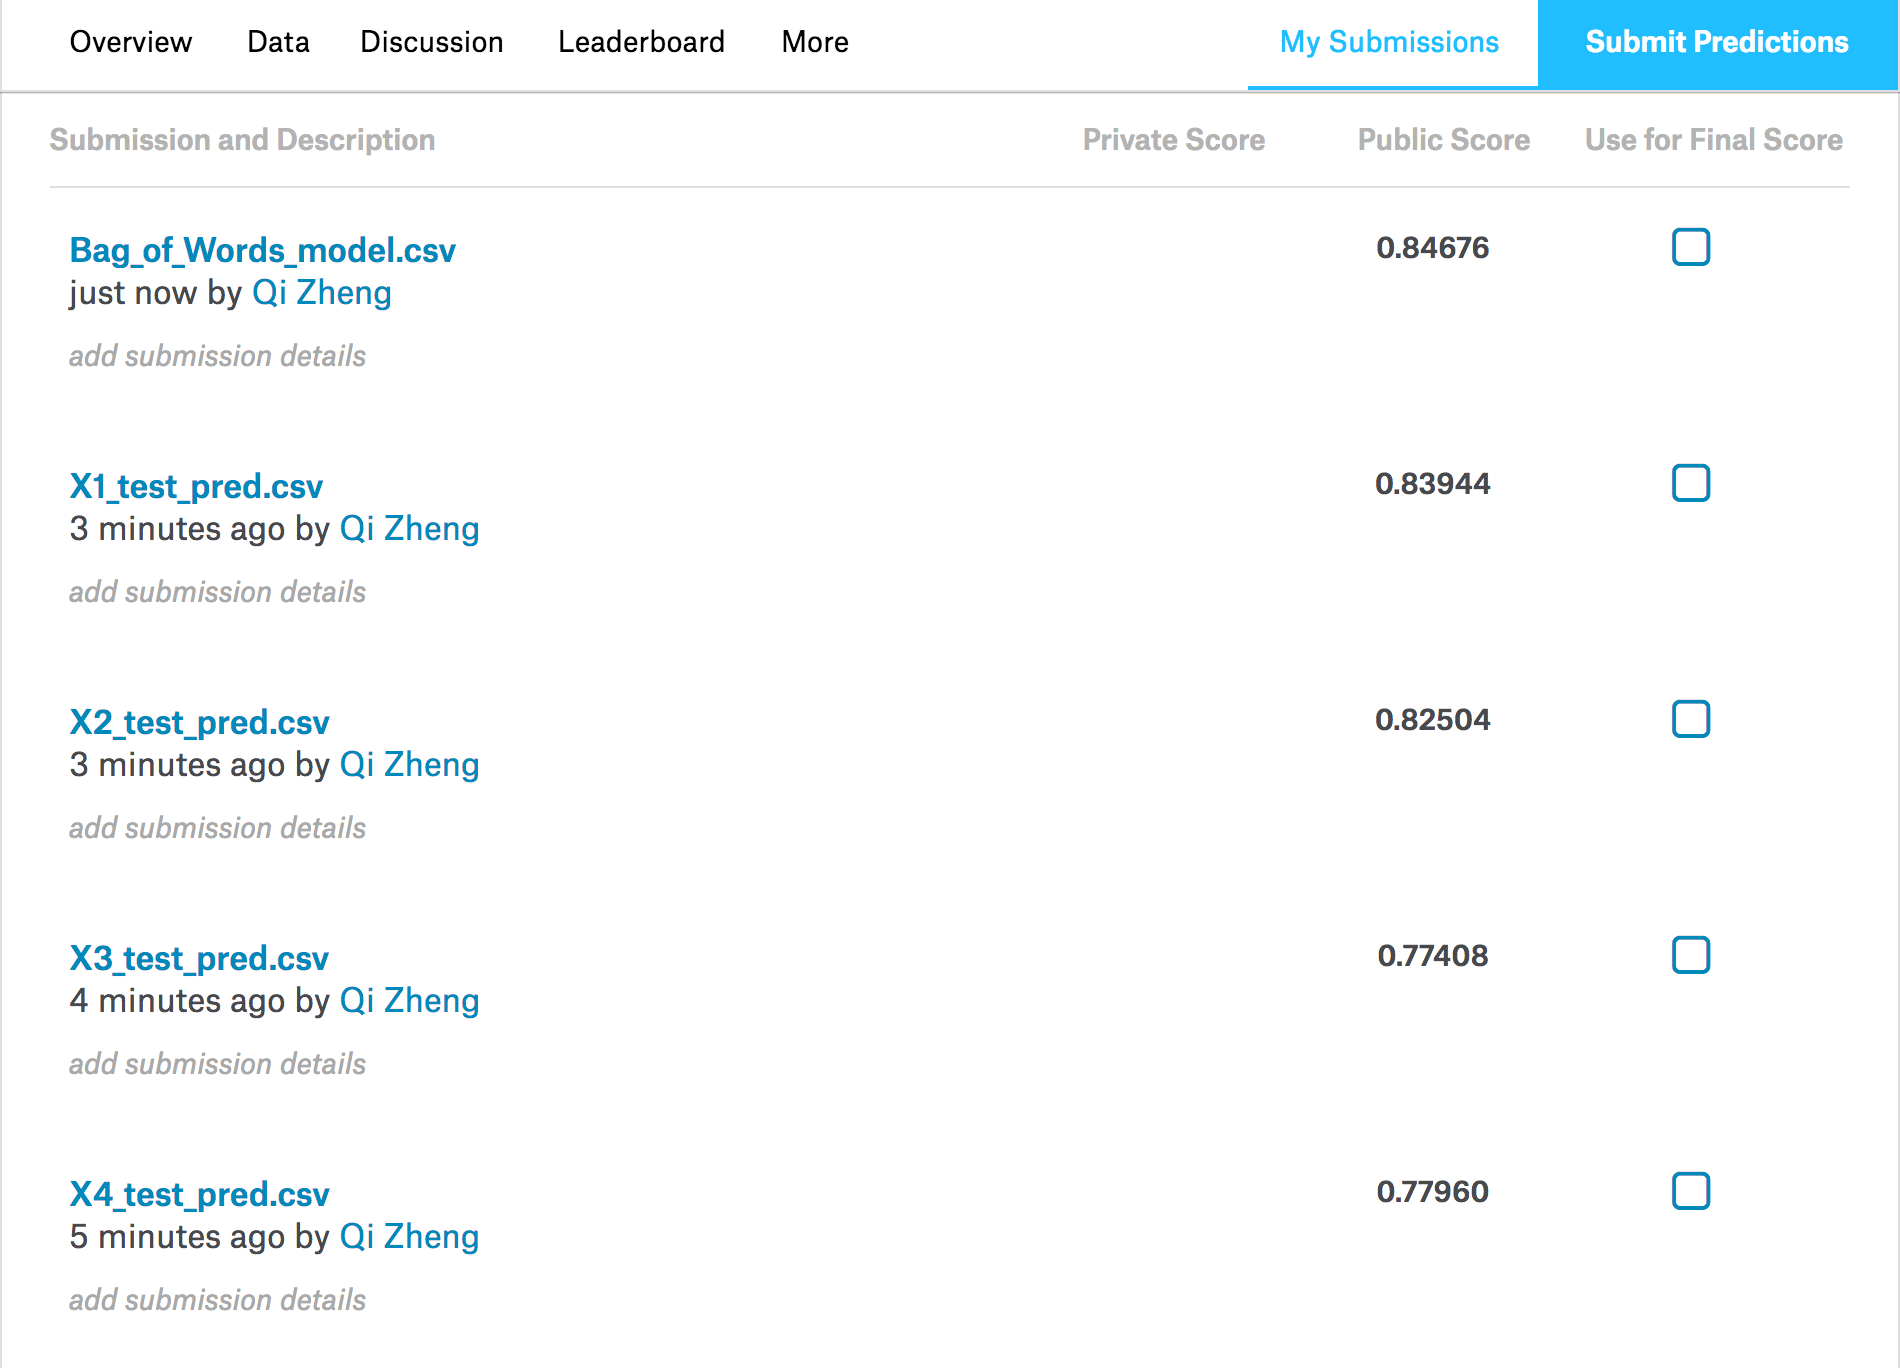

In [2]:
Image(filename='Scores.png')

# 1. Word2Vec

## 1a. Generate Vector Representation Collection Z1

In [21]:
class Word2VecUtility(object):
    """Utility class for processing raw HTML text into segments for further learning"""

    @staticmethod
    def review_to_wordlist( review, remove_stopwords=False ):
        # Function to convert a document to a sequence of words,
        # optionally removing stop words.  Returns a list of words.
        #
        # 1. Remove HTML
        review_text = BeautifulSoup(review, "lxml").get_text()
        #
        # 2. Remove non-letters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        #
        # 3. Convert words to lower case and split them
        words = review_text.lower().split()
        #
        # 4. Optionally remove stop words (false by default)
        if remove_stopwords:
            stops = set(stopwords.words("english"))
            words = [w for w in words if not w in stops]
        #
        # 5. Return a list of words
        return(words)

    # Define a function to split a review into parsed sentences
    @staticmethod
    def review_to_sentences( review, tokenizer, remove_stopwords=False ):
        # Function to split a review into parsed sentences. Returns a
        # list of sentences, where each sentence is a list of words
        #
        # 1. Use the NLTK tokenizer to split the paragraph into sentences
        raw_sentences = tokenizer.tokenize(review.strip())
        #
        # 2. Loop over each sentence
        sentences = []
        for raw_sentence in raw_sentences:
            # If a sentence is empty, skip it
            if len(raw_sentence) > 0:
                # Otherwise, call review_to_wordlist to get a list of words
                sentences.append(Word2VecUtility.review_to_wordlist( raw_sentence, \
                  remove_stopwords))
        #
        # Return the list of sentences (each sentence is a list of words,
        # so this returns a list of lists
        return sentences

In [22]:
def getCleanReviews(reviews):
    clean_reviews = []
    for review in reviews["review"]:
        clean_reviews.append(Word2VecUtility.review_to_wordlist(review, remove_stopwords=True ))
    return clean_reviews

In [23]:
# Read data from files 
train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print("Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews\n" % (train["review"].size,  
test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [24]:
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
# ****** Set parameters and train the word2vec model
#
# Import the built-in logging module and configure it so that Word2Vec
# creates nice output messages
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set values for various parameters
num_features = 100    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 5           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

In [16]:
# Initialize and train the model
print("Training Word2Vec model...")
model_Z1 = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, \
                 window = context, sample = downsampling, seed=1)

In [353]:
# Since we don't plan to train the model any further, calling
# init_sims will make the model much more memory-efficient.

model_Z1.init_sims(replace=True)

model_name = "100features_40minwords_5context"
model_Z1.save(model_name)

In [174]:
model_Z1 = model_Z1.wv
Z1 = model_Z1.syn0
print(Z1.shape)
np.save("Z1", Z1)

(16490, 100)


## 1b. Generate Vector Representation Collection Z2

In [352]:
model_Z2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [183]:
Z2_prim = model_Z2.syn0
print(Z2_prim.shape)

index2word_Z2_prim = model_Z2.index2word
print(len(index2word_Z2_prim))

(3000000, 300)
3000000


In [218]:
# Index2word is a list that contains the names of the words in
# the model's vocabulary. Convert it to a set, for speedç = model_Z1√.index2word
index2word_set = set(model_Z1.index2word)
index2word_Z1 = model_Z1.index2word
print("Length of index2word_Z1: ", len(index2word_Z1))
print("Length of index2word_set: ", len(index2word_set))


# Filter out all the words in the Google's pre-trained model
# that aren't in the reviews (of our smaller model)
# to reduce the size of Z2
total_cnt = len(index2word_Z2_prim)
print(total_cnt, end='\n')

Z2 = []    
index2word_Z2 = []

for i in range(total_cnt):
    key = index2word_Z2_prim[i]
    if (key in index2word_set):
        Z2.append(Z2_prim[i])
        index2word_Z2.append(key)

Z2 = np.array(Z2)
print("Z2 shape: ", Z2.shape)
print("length of index2word_Z2:", len(index2word_Z2))

Length of index2word_Z1:  16490
Length of index2word_set:  16490
3000000
Z2 shape:  (15181, 300)
length of index2word_Z2: 15181


## 1c. K-Means Clustering with K=10

In [359]:
# Set "k" (num_clusters) to be 1/10 of the word vector size
k1 = (int)(Z1.shape[0]/10)
k2 = (int)(Z2.shape[0]/10)
# Initalize a k-means object and use it to extract centroids on Z1
km_Z1 = KMeans(n_clusters = k1)
km_Z2 = KMeans(n_clusters = k2)

#************************** K-Means Clustering on Z1 **************************#
start = time.time() # Start time
# Extract centroids on Z2
idx_Z1 = km_Z1.fit_predict(Z1)
# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print("Time taken for K-Means(K=%d) clustering on Z1: "%(k1), elapsed, "seconds.")


#************************** K-Means Clustering on Z2 **************************#
start = time.time()
idx_Z2 = km_Z2.fit_predict(Z2)

end = time.time()
elapsed = end - start
print("Time taken for K-Means(K=%d) clustering on Z2: "%(k2), elapsed, "seconds.")

Time taken for K-Means(K=1649) clustering on Z1:  122.55553197860718 seconds.
Time taken for K-Means(K=1518) clustering on Z2:  253.5598006248474 seconds.


In [360]:
idx_Z1 = np.array(idx_Z1)
idx_Z2 = np.array(idx_Z2)

print(idx_Z1.shape)
print(idx_Z2.shape)

print(Z1.shape)
print(Z2.shape)

(16490,)
(15181,)
(16490, 100)
(15181, 300)


In [361]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_Z1 = dict(zip(index2word_Z1, idx_Z1))
word_centroid_Z2 = dict(zip(index2word_Z2, idx_Z2))

In [240]:
# # create a list 10 clusters
# # each cluster is represented by a numpy array

# # initialize a collection of clusters
# def gen_coll():
#     coll = []
#     [coll.append([]) for i in range(10)]
#     return coll

# # Allocate reviews in Z
# def assign_Z(Z, idx_Z, coll_Z):
#     for i in range(idx_Z.shape[0]):
#         coll_Z[idx_Z[i]].append(Z[i])
#     return coll_Z

# # Check the shape of all 10 cluters in coll_Z1 and coll_Z2
# print("\nDimension of 10 clusters in Z1:")
# for i in range(10):
#     print("Shape of Cluster %d: "%(i), coll_Z1[i].shape)

# print("\nDimension of 10 clusters in Z2:")
# for i in range(10):
#     print("Shape of Cluster %d: "%(i), coll_Z2[i].shape)

# # Convert each cluster from list to array
# coll_Z1 = [np.array(clu) for clu in coll_Z1]
# coll_Z2 = [np.array(clu) for clu in coll_Z2]

# coll_Z1 = gen_coll()
# coll_Z2 = gen_coll()

# coll_Z1 = assign_Z(Z1, idx_Z1, coll_Z1)
# coll_Z2 = assign_Z(Z2, idx_Z2, coll_Z2)

# # Convert each cluster from list to array
# coll_Z1 = [np.array(clu) for clu in coll_Z1]
# coll_Z2 = [np.array(clu) for clu in coll_Z2]

In [362]:
def print_closest_20(km, Z, index2word, word_centroid):
    for i in range(10):
        dist = km.transform(Z)[:, i]
        ind = np.argsort(dist)[::]
        print('\nCluster %d: '%(i), end = '\t')
        cnt = 0
        for j in ind:
            if word_centroid[index2word[j]]==i:
                print(index2word[j], end = ', ')
                cnt += 1
                if cnt>=20:
                    break
        print()

### - Print 20 words from each clusters that are closest to the centroids for the first 10 clusters in Z1

In [363]:
print_closest_20(km_Z1, Z1, index2word_Z1, word_centroid_Z1)


Cluster 0: 	censorship, preservation, worldwide, backlash, quo, scorn, prestige, reserve, controversy, code, 

Cluster 1: 	armstrong, hartman, ernie, robinson, sanders, marshall, howell, windsor, wheeler, respectively, baker, bonnie, clyde, randolph, dick, hicks, brady, burns, raft, olsen, 

Cluster 2: 	ambulance, elevator, rv, auto, earthquake, explosion, ambush, axe, airplane, asylum, autopsy, airport, arrow, overnight, abandoned, exit, accident, ferrari, 

Cluster 3: 	bimbos, babes, strippers, blondes, cheerleaders, chicks, hookers, ninjas, virgins, queens, jive, housewives, 

Cluster 4: 	mistress, governess, maid, countess, stepmother, granddaughter, widow, aurora, granny, sweetheart, hubby, guardian, necklace, descendant, bride, queen, maiden, avenging, elvira, 

Cluster 5: 	baffling, fabricated, puzzling, unclear, undermines, convenient, 

Cluster 6: 	reused, canned, 

Cluster 7: 	literary, literature, cinematic, purest, historical, shakespeare, endearment, 

Cluster 8: 	swingin

### - Print 20 words from each clusters that are closest to the centroids for the first 10 clusters in Z2

In [364]:
print_closest_20(km_Z2, Z2, index2word_Z2, word_centroid_Z2)


Cluster 0: 	promo, promos, promotional, teaser, tagline, 

Cluster 1: 	worried, worry, concerned, worrying, picky, qualms, 

Cluster 2: 	vaguely, darkly, 

Cluster 3: 	questioning, question, questioned, matter, 

Cluster 4: 	jacqueline, greer, vivian, corbett, erika, portman, boyer, sheridan, philippe, percy, eileen, howell, buchanan, vinci, yvonne, clooney, needn, fenton, keating, kirsten, 

Cluster 5: 	meyers, hoffman, carla, jensen, claudia, simone, ritchie, susie, carlson, gallagher, cynthia, rubin, norris, elena, novak, goodman, alexandra, mcmahon, fleming, trish, 

Cluster 6: 	painfully, frighteningly, shockingly, disturbingly, stunningly, excruciatingly, achingly, unbearably, uncomfortably, dangerously, eerily, numbingly, tragically, 

Cluster 7: 	analyzing, examining, analyze, evaluate, reviewing, review, determine, analysis, studying, judging, researching, tracking, measured, monitor, calculated, calculating, interviewing, modeling, 

Cluster 8: 	die, died, dies, 

Cluster 9:

## 1d. Create design matrices X1, X2

In [365]:
def create_bag_of_centroids(wordlist, word_centroid):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max(word_centroid.values()) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros(num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count by one
    for word in wordlist:
        if word in word_centroid:
            index = word_centroid[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

* __Create two design matrices (X1, X2) for the training set based on Z1, and Z2__  
* __Create corresponding design matrices for the test reviews (X1_test, X2_test)__

In [26]:
# Clean training and test reviews
clean_train_reviews = getCleanReviews(train)
clean_unlabled_train = getCleanReviews(unlabeled_train)
clean_test_reviews = getCleanReviews(test)

In [367]:
# Create design matrices for the training reviews
# Pre-allocate an array for the training set bags of centroids (for speed)
X1 = np.zeros((train["review"].size, k1), dtype="float32" )
X2 = np.zeros((train["review"].size, k2), dtype="float32" )

# Transform the training set reviews into bags of centroids
counter = 0
for review in clean_train_reviews:
    X1[counter] = create_bag_of_centroids(review, word_centroid_Z1)
    X2[counter] = create_bag_of_centroids(review, word_centroid_Z2)
    counter += 1
    
    
# Repeat for test reviews 
X1_test = np.zeros((test["review"].size, k1), dtype="float32")
X2_test = np.zeros((test["review"].size, k2), dtype="float32")

counter = 0
for review in clean_test_reviews:
    X1_test[counter] = create_bag_of_centroids(review, word_centroid_Z1)
    X2_test[counter] = create_bag_of_centroids(review, word_centroid_Z2)
    counter += 1

In [369]:
# check the dimensions for train and test sets
print(X1.shape)
print(X1_test.shape)

print(X2.shape)
print(X2_test.shape)

(25000, 1649)
(25000, 1649)
(25000, 1518)
(25000, 1518)


## 1e. Save X1, X2, X1_test, X2_test

In [372]:
np.save("X1", X1)
np.save("X1_test", X1_test)
np.save("X2", X2)
np.save("X2_test", X2_test)

---------------------------------------------------------------------------------------------------------------------

# 2. Topic Modeling

## 2a, 2b. LDA Topic Modeling

In [27]:
clean_complete_train = clean_train_reviews + clean_unlabled_train

In [28]:
from gensim import corpora, models

In [29]:
dic = corpora.Dictionary(clean_complete_train)
corpus = [dic.doc2bow(text) for text in clean_complete_train]

lda_10 = models.LdaModel(corpus, id2word = dic, num_topics = 10)
lda_20 = models.LdaModel(corpus, id2word = dic, num_topics = 20)

#### Genetate X3, X4 design matrices

In [31]:
corpus_tr = [dic.doc2bow(text) for text in clean_train_reviews]

ldaX3 = lda_10[corpus_tr]
ldaX4 = lda_20[corpus_tr]

In [33]:
L = len(clean_train_reviews)

X3 = np.empty([L, 10])
X4 = np.empty([L, 20])

for i in range(L):
    for (topic1, data1) in ldaX3[i]:
        X3[i, topic1] = data1
    for (topic2, data2) in ldaX4[i]:
        X4[i, topic2] = data2

In [54]:
np.save("X3", X3)
np.save("X4", X4)

#### Genetate X3_test, X4_test design matrices for the test data

In [34]:
corpus_test = [dic.doc2bow(text) for text in clean_test_reviews]

ldaX3_tst = lda_10[corpus_test]
ldaX4_tst  = lda_20[corpus_test]

In [35]:
Lts = len(clean_test_reviews)
X3_test = np.empty([Lts, 10])
X4_test = np.empty([Lts, 20])

for i in range(Lts):
    for (topic1, data1) in ldaX3_tst[i]:
        X3_test[i, topic1] = data1
    for (topic2, data2) in ldaX4_tst[i]:
        X4_test[i, topic2] = data2

In [53]:
np.save("X3_test", X3_test)
np.save("X4_test", X4_test)

#### Print tables of words for each of the topics

In [36]:
# for Part(a) with ntopics = 10
lda_10.print_topics(-1, 10)

[(0,
  '0.036*"show" + 0.014*"series" + 0.012*"episode" + 0.008*"tv" + 0.007*"shows" + 0.006*"one" + 0.006*"episodes" + 0.005*"season" + 0.005*"new" + 0.005*"like"'),
 (1,
  '0.053*"movie" + 0.015*"like" + 0.012*"one" + 0.011*"really" + 0.011*"good" + 0.010*"see" + 0.009*"would" + 0.008*"people" + 0.008*"think" + 0.008*"movies"'),
 (2,
  '0.007*"one" + 0.004*"film" + 0.004*"grant" + 0.003*"charlie" + 0.003*"like" + 0.003*"rock" + 0.003*"comedy" + 0.003*"john" + 0.003*"team" + 0.003*"back"'),
 (3,
  '0.006*"one" + 0.005*"version" + 0.004*"well" + 0.003*"king" + 0.003*"musical" + 0.003*"animation" + 0.003*"also" + 0.003*"original" + 0.003*"like" + 0.003*"cartoon"'),
 (4,
  '0.040*"film" + 0.015*"movie" + 0.011*"one" + 0.011*"great" + 0.009*"good" + 0.008*"best" + 0.008*"story" + 0.007*"well" + 0.006*"time" + 0.006*"actors"'),
 (5,
  '0.009*"film" + 0.007*"story" + 0.006*"one" + 0.006*"horror" + 0.006*"like" + 0.005*"japanese" + 0.004*"well" + 0.004*"also" + 0.004*"movie" + 0.004*"good"')

In [37]:
# for Part(b) with ntopics = 20
lda_20.print_topics(-1, 10)

[(0,
  '0.020*"movie" + 0.017*"film" + 0.012*"bad" + 0.011*"one" + 0.009*"good" + 0.009*"like" + 0.008*"horror" + 0.008*"acting" + 0.008*"even" + 0.007*"plot"'),
 (1,
  '0.015*"like" + 0.014*"funny" + 0.014*"bad" + 0.012*"movie" + 0.012*"even" + 0.010*"one" + 0.008*"comedy" + 0.008*"would" + 0.007*"get" + 0.007*"ever"'),
 (2,
  '0.008*"western" + 0.007*"one" + 0.005*"kevin" + 0.004*"bill" + 0.003*"keaton" + 0.003*"steve" + 0.003*"westerns" + 0.003*"like" + 0.003*"oliver" + 0.003*"john"'),
 (3,
  '0.020*"war" + 0.008*"world" + 0.008*"american" + 0.005*"one" + 0.005*"battle" + 0.004*"country" + 0.004*"military" + 0.004*"japanese" + 0.004*"soldiers" + 0.004*"army"'),
 (4,
  '0.007*"film" + 0.006*"role" + 0.006*"one" + 0.005*"young" + 0.005*"wife" + 0.005*"plays" + 0.004*"cast" + 0.004*"man" + 0.004*"best" + 0.004*"played"'),
 (5,
  '0.010*"one" + 0.007*"house" + 0.005*"horror" + 0.005*"man" + 0.005*"old" + 0.005*"dead" + 0.005*"little" + 0.005*"like" + 0.005*"back" + 0.004*"family"'),
 (6

---------------------------------------

# 3. Classification Experiment

## 3a. Train 4 Random Forest Classifiers




* ### Using GridSearch with 5-fold cross-validation to tune hyperparameters for 4 classifiers

In [493]:
# Fit the forest to the training set, using the 4 design
# matrices and the sentiment labels as the response variable

# target: sentiment labels
y = np.array(train["sentiment"])

In [42]:
# ****************** Parameter Tuning ***********************
# GridSearch with 5-fold cross-validation

def run_GridSearchCV(X, y):
    t_start = time.time()
    clf = RFC(oob_score = True, random_state=42)
    param_grid = { "n_estimators": [100, 200, 500],
#                   "criterion" : ["gini", "entropy"],  # default works better
                  "max_features": [None, 'auto', 'log2']    # default works better
                 }
    grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5)
    grid_search.fit(X, y)
    print(grid_search.best_params_)
    print('Run Time:', time.time()-t_start, 'sec')

In [38]:
def cal_scores(X, y, n, clf):
    AUC = []
    Accur = []
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    k_fold = cross_validation.KFold(n=y_train.shape[0],n_folds=n)
    for (tr, ts) in k_fold:
        clf.fit(x_train[tr], y_train[tr])
        prob = clf.predict_proba(x_train[ts])
        pred = clf.predict(x_train[ts])
        auc = roc_auc_score(y_train[ts], prob[:, 1])
        accur = accuracy_score(y_train[ts], pred, normalize=True)
        AUC.append(auc)
        Accur.append(accur)    
    meanAUC = np.array(AUC).mean()
    meanAccur = np.array(Accur).mean()
    print('Mean AUC for %d folds CV: '%n, meanAUC)
    print('Mean Accuracy for %d folds CV: '%n, meanAccur)
    return meanAUC, meanAccur

In [39]:
def roc_test(clf, x_train, y_train, x_test, y_test):

    clf.fit(x_train, y_train)
    y_score = (clf.predict_proba(x_test))[:, 1]
    
    # Data for plotting ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

In [40]:
def save_redults(clf, X, y, X_test, test, outputfile):
    #
    clf = clf.fit(X, y)
    result = clf.predict(X_test)
    
    # Copy the results to a pandas dataframe with an "id" column and
    # a "sentiment" column
    output = pd.DataFrame(data={"id":test["id"], "sentiment":result})
    
    # Use pandas to write the comma-separated output file
    output.to_csv(outputfile+".csv", index=False, quoting=3)

In [523]:
run_GridSearchCV(X1, y)

{'n_estimators': 500}
Run Time: 529.0723531246185 sec


In [521]:
run_GridSearchCV(X3, y)

{'max_features': 'auto', 'n_estimators': 500}
Run Time: 453.2882318496704 sec


In [44]:
run_GridSearchCV(X4, y)

{'max_features': 'auto', 'n_estimators': 500}
Run Time: 273.0956697463989 sec


In [41]:
clf = RFC(n_estimators=100, oob_score = True, random_state = 42)

print('5-fold CV scores for X1:')
AUC_X1, Accur_X1 = cal_scores(X1, y, 5, clf)

print('5-fold CV scores for X2:')
AUC_X2, Accur_X2 = cal_scores(X2, y, 5, clf)

print('5-fold CV scores for X3:')
AUC_X3, Accur_X3 = cal_scores(X3, y, 5, clf)

print('5-fold CV scores for X4:')
AUC_X4, Accur_X4 = cal_scores(X4, y, 5, clf)

5-fold CV scores for X1:
Mean AUC for 5 folds CV:  0.90710323919
Mean Accuracy for 5 folds CV:  0.83295
5-fold CV scores for X2:
Mean AUC for 5 folds CV:  0.896772404529
Mean Accuracy for 5 folds CV:  0.8181
5-fold CV scores for X3:
Mean AUC for 5 folds CV:  0.848314228517
Mean Accuracy for 5 folds CV:  0.7902
5-fold CV scores for X4:
Mean AUC for 5 folds CV:  0.855944004839
Mean Accuracy for 5 folds CV:  0.7831


In [58]:
clf = RFC(n_estimators=200, oob_score = True, random_state = 42)

X = [X1, X2, X3, X4]
Name = ['X1','X2', 'X3', 'X4']
fpr=[]
tpr=[]
roc_auc = []

for i in range(4):
    x_train, x_test, y_train, y_test = train_test_split(X[i], y, test_size=0.2, random_state=0)
    fpr1, tpr1, roc_auc1 = roc_test(clf, x_train, y_train, x_test, y_test)
    fpr.append(fpr1)
    tpr.append(tpr1)
    roc_auc.append(roc_auc1)

## 3b. Plot ROCs for Each Classifier

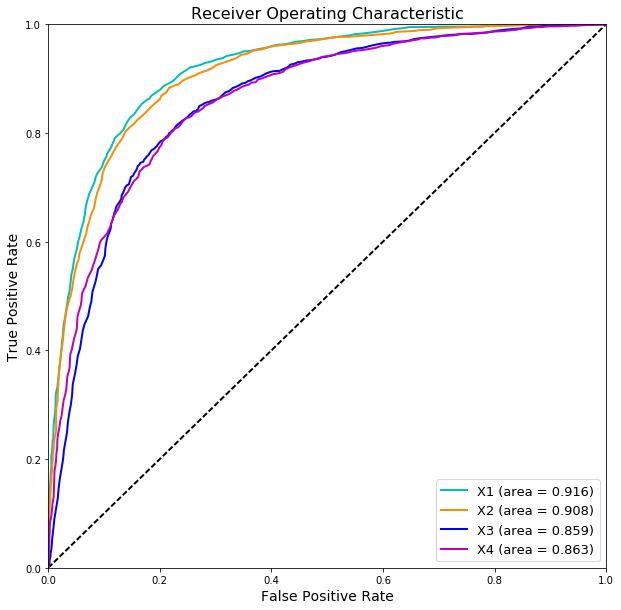

In [59]:
plt.figure(figsize=(10, 10))
lw = 2
pltcolors = ['c', 'darkorange', 'b', 'm']
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=pltcolors[i],
             lw=lw, label= Name[i] + ' (area = %0.3f)' % roc_auc[i])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc=4, prop={'size':13})
plt.show()   

In [60]:
Xtest = [X1_test, X2_test, X3_test, X4_test]

for i in range(2, 4):
    save_redults(clf, X[i], y, Xtest[i], test, Name[i]+'_test_pred')

## 3c. Analyses

### - Submit to Kaggle

In [61]:
# Image(filename='')

### - Compare Results with Bag-of-Words Method

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

print ("Creating the bag of words...\n")
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer=lambda doc: doc, lowercase=False,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

    
# Fits the model and learns the vocabulary, and transforms our training data
# into feature vectors. The input to fit_transform should be a list ofstrings.
X_bow = vectorizer.fit_transform(clean_train_reviews)
np.asarray(X_bow)


# ******* Train a random forest using the bag of words
print("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RFC(n_estimators = 100)

# Fit the forest to the training set, using the bag of words as
# features and the sentiment labels as the response variable
forest = forest.fit(X_bow, y)


# Get a bag of words for the test set, and convert to a numpy array
X_bow_test = vectorizer.transform(clean_test_reviews)
np.asarray(X_bow_test)


x_bow_train, x_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow, y, test_size=0.2, random_state=0)
fprbow, tprbow, roc_auc_bow = roc_test(forest, x_bow_train, y_bow_train, x_bow_test, y_bow_test)

fpr.append(fprbow)
tpr.append(tprbow)
roc_auc.append(roc_auc_bow)

Creating the bag of words...

Training the random forest...


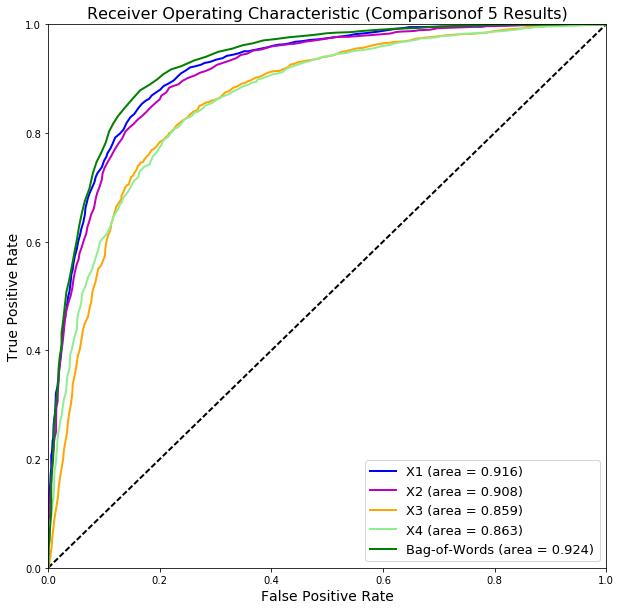

In [63]:
Name.append('Bag-of-Words')

plt.figure(figsize=(10, 10))
pltcolors = ['b', 'm', 'orange', 'lightgreen',  'g']
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')

for i in range(5):
    plt.plot(fpr[i], tpr[i], color=pltcolors[i],
             lw=lw, label= Name[i] + ' (area = %0.3f)' % roc_auc[i])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver Operating Characteristic (Comparisonof 5 Results)', fontsize = 16)
plt.legend(loc=4, prop={'size':13})
plt.show()  

In [64]:
# Use the random forest to make sentiment label predictions
print("Predicting test labels...\n")
bow_pred = forest.predict(X_bow_test)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"id":test["id"], "sentiment":bow_pred} )

# Use pandas to write the comma-separated output file
output.to_csv('Bag_of_Words_model.csv', index=False, quoting=3)
print("Wrote results to Bag_of_Words_model.csv")

Predicting test labels...

Wrote results to Bag_of_Words_model.csv


### - Discussions

__1.__ After experimenting with Word2Vec with bag of centroids and LDA topic modeling, we can find that for the movie review dataset, Word2Vec with bag of centroids works better. Generally, using the Word2Vec training model from the movie review dataset itself and from the Google pre-trained model does not make big difference. The two topic models we trained were a little bit worse at predicting sentiment classification in this problem. However, by increasing the number of topics, we can get better results. In my codes, I did not apply TFIDF on top of the LDA model, in sparse and noisy dataset like reviews, TFIDF generally does not work so well. If bag-of-words method is included in comparison, it actually worked best for this problem.

__2.__ Suggestions for Better Results:

1) Using both labled and unlabled data (combined) for modeling training, this would yield much better results, especially for the LDA model.

2) Carefully tune the hyperparameters. We can start with a wide range of parameters and use 5-fold (or 10-fold) cross-validation to narrow down the range for better scores. Then we can use GridSearch to refine the search and choose the set of parameters for better results.

3) Choose better feature engineering: In extreme cases, extreme feature engineering could push attribute decomposition and aggregation seen in data preparation to the limits.

4) When training your LDA model, combine both labeled and unlabeled to make a larger training set to train your LDA model, especially in this case where the corpus of unlabeled training and testing sets are very different. 